# Wake county restaurant inspection project by Paige McKenzie
Implements methods discussed in related [blog post]().

Data courtesy of Wake County Open Data (pulled 7/3/19):
* [Restaurants](https://data-wake.opendata.arcgis.com/datasets/restaurants-in-wake-county)
* [Inspections](https://data-wake.opendata.arcgis.com/datasets/food-inspections)
* [Violations](https://data-wake.opendata.arcgis.com/datasets/food-inspection-violations)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy

### Import data to Pandas dataframes

In [2]:
rest = pd.read_csv('./data/Restaurants_in_Wake_County.csv', index_col=['OBJECTID'],
                  parse_dates=['RESTAURANTOPENDATE'], infer_datetime_format=True)

insp = pd.read_csv('./data/Food_Inspections.csv', index_col=['OBJECTID'],
                  parse_dates=['DATE_'], infer_datetime_format=True)

viol = pd.read_csv('./data/Food_Inspection_Violations.csv',
                  parse_dates=['INSPECTDATE'], infer_datetime_format=True, low_memory=False)

## General data exploration and cleaning
### Restaurants dataset

In [3]:
rest.head(2)

HSISID                            NAME             ADDRESS1  \
OBJECTID                                                                    
2001      4092030273    RARE EARTH FARMS (WCID #512)   407 GLENWOOD  AVE    
2002      4092015000  GRACE Christian School Kitchen  801  Buck Jones RD    

         ADDRESS2     CITY  STATE POSTALCODE     PHONENUMBER  \
OBJECTID                                                       
2001          NaN  RALEIGH    NaN      27606  (919) 349-6080   
2002          NaN  RALEIGH    NaN      27606  (919) 783-6618   

         RESTAURANTOPENDATE       FACILITYTYPE  PERMITID          X  \
OBJECTID                                                              
2001             2015-01-16  Mobile Food Units     18359 -78.647761   
2002             2007-11-06         Restaurant      3377 -78.736937   

                  Y GEOCODESTATUS  
OBJECTID                           
2001      35.785405             M  
2002      35.771907             M

In [4]:
pd.concat([rest.dtypes.rename("Datatype"),
           rest.apply(pd.Series.nunique).rename("# of unique values"),
            rest.apply(pd.Series.isnull).mean().rename("% of missing values")],
          axis=1, sort=True)

Datatype  # of unique values  % of missing values
ADDRESS1                    object                3150             0.000000
ADDRESS2                    object                 265             0.886840
CITY                        object                  14             0.189159
FACILITYTYPE                object                  10             0.000000
GEOCODESTATUS               object                   3             0.000000
HSISID                       int64                3579             0.000000
NAME                        object                3449             0.000000
PERMITID                     int64                3579             0.000000
PHONENUMBER                 object                3059             0.044426
POSTALCODE                  object                 539             0.000000
RESTAURANTOPENDATE  datetime64[ns]                2217             0.000000
STATE                      float64                   0             1.000000
X                          float64                2102             0.000000
Y                          float64                2102             0.000000

In [5]:
# city is not standardized - lowercase, replace hyphen with space
rest['CITY'] = rest['CITY'].str.lower().str.replace('-', ' ')

# combine any 'CITY' value with less than 10 data points into an "other" category, treat nulls the same
rest.loc[rest['CITY'].isin(rest['CITY'].value_counts()[rest['CITY'].value_counts()<10].index),
        'CITY'] = 'other'
rest['CITY'].fillna('other', inplace=True)

In [6]:
# postal code isn't standardized either - abbreviate to 5 digit format, treat as integer
rest['POSTALCODE'] = rest['POSTALCODE'].apply(lambda st:int(st[:5]))

In [7]:
from re import findall

# clean name by removing odd characters, lowercase (combining weird apostrophes)
rest['NAME'] = rest['NAME'].str.lower().str.replace('`', "'").apply(lambda x:' '.join(findall(r"([a-z'-]+)(?=\s|$)", x)))

In [8]:
# there is no reason to retain the STATE field - it has no information, and all of Wake County is in NC anyway
rest.drop('STATE', axis=1, inplace=True)

In [9]:
pd.concat([rest.dtypes.rename("Datatype"),
           rest.apply(pd.Series.nunique).rename("# of unique values"),
            rest.apply(pd.Series.isnull).mean().rename("% of missing values")],
          axis=1, sort=True)

Datatype  # of unique values  % of missing values
ADDRESS1                    object                3150             0.000000
ADDRESS2                    object                 265             0.886840
CITY                        object                  13             0.000000
FACILITYTYPE                object                  10             0.000000
GEOCODESTATUS               object                   3             0.000000
HSISID                       int64                3579             0.000000
NAME                        object                2485             0.000000
PERMITID                     int64                3579             0.000000
PHONENUMBER                 object                3059             0.044426
POSTALCODE                   int64                  57             0.000000
RESTAURANTOPENDATE  datetime64[ns]                2217             0.000000
X                          float64                2102             0.000000
Y                          float64                2102             0.000000

### Inspections dataset

In [10]:
# rename date column to match other table
insp.rename(columns={'DATE_':'INSPECTDATE'}, inplace=True)
insp.head(2)

HSISID  SCORE INSPECTDATE            DESCRIPTION        TYPE  \
OBJECTID                                                                     
1001      4092015443   96.0  2015-03-24                    NaN  Inspection   
1002      4092015443   94.0  2015-09-25  Follow-Up: 10/05/2015  Inspection   

                 INSPECTOR  PERMITID  
OBJECTID                              
1001        Caroline Suggs      4768  
1002      Jennifer Edwards      4768

In [11]:
insp['HSISID'].isin(rest['HSISID']).mean()

0.9722470155082004

We need to be able to connect inspections to restaurants, so we'll only retain rows where this is possible, about 97% of this dataset.

In [12]:
insp = insp[insp['HSISID'].isin(rest['HSISID'])]

In [13]:
pd.concat([insp.dtypes.rename("Datatype"),
           insp.apply(pd.Series.nunique).rename("# of unique values"),
            insp.apply(pd.Series.isnull).mean().rename("% of missing values")],
          axis=1, sort=True)

Datatype  # of unique values  % of missing values
DESCRIPTION          object               10828             0.371948
HSISID                int64                3510             0.000000
INSPECTDATE  datetime64[ns]                1880             0.000000
INSPECTOR            object                  50             0.000000
PERMITID              int64                3510             0.000000
SCORE               float64                  52             0.000000
TYPE                 object                   2             0.000000

### Violations dataset

In [14]:
viol.head(2)

OBJECTID  HSISID INSPECTDATE         CATEGORY    STATECODE CRITICAL  \
0      1001     NaN  2014-02-25  Approved Source  .2653,.2655      Yes   
1      1002     NaN  2014-05-22  Approved Source  .2653,.2655      Yes   

   QUESTIONNO VIOLATIONCODE             SEVERITY  \
0          12      3-203.12  Priority Foundation   
1          12      3-203.12  Priority Foundation   

                                           SHORTDESC       INSPECTEDBY  \
0  Required records available: shellstock tags, p...  Melissa Harrison   
1  Required records available: shellstock tags, p...  Jennifer Edwards   

                                            COMMENTS  POINTVALUE  \
0  3-203.12; Priority Foundation; Clams stored in...         2.0   
1  3-203.12; Priority Foundation; Shellstock tags...         0.0   

  OBSERVATIONTYPE VIOLATIONTYPE  CDCRISKFACTOR CDCDATAITEM  PERMITID  
0             Out             R  Unsafe Source         NaN      4067  
1             Out            VR  Unsafe Source         NaN      7605

In [15]:
pd.concat([viol.dtypes.rename("Datatype"),
           viol.apply(pd.Series.nunique).rename("# of unique values"),
            viol.apply(pd.Series.isnull).mean().rename("% of missing values")],
          axis=1, sort=True)

Datatype  # of unique values  % of missing values
CATEGORY                 object                  25             0.000000
CDCDATAITEM              object                   5             0.926013
CDCRISKFACTOR            object                   5             0.833124
COMMENTS                 object              288664             0.001692
CRITICAL                 object                   2             0.045759
HSISID                  float64                   0             1.000000
INSPECTDATE      datetime64[ns]                1893             0.000000
INSPECTEDBY              object                  54             0.000245
OBJECTID                  int64              317906             0.000000
OBSERVATIONTYPE          object                   5             0.000937
PERMITID                  int64                5416             0.000000
POINTVALUE              float64                   7             0.000000
QUESTIONNO                int64                  54             0.000000
SEVERITY                 object                   3             0.045759
SHORTDESC                object                  83             0.000000
STATECODE                object                  19             0.000000
VIOLATIONCODE            object                 339             0.000000
VIOLATIONTYPE            object                   3             0.481060

The data came without HSISID populated, but we may be able to crosswalk with the other tables to get this information. However, it is worth noting that the `violations` table has dramatically more unique `PERMITID` values than the other tables, meaning it will be impossible to connect these violations to permits/restaurants in the dataset.

In [16]:
viol['PERMITID'].isin(insp['PERMITID']).mean()

0.17445722949551126

In fact, it looks like about 17% of the rows in the `violations` table can be connected to the others, so this is the subset we'll keep.

In [17]:
# check there is one HSISID for each PERMITID
assert (rest.groupby('PERMITID')['HSISID'].nunique()>1).sum()==0

viol = viol.drop('HSISID', axis=1).join(insp.set_index('PERMITID')['HSISID'].drop_duplicates(),
         on='PERMITID', how='inner')

In [18]:
pd.concat([viol.dtypes.rename("Datatype"),
           viol.apply(pd.Series.nunique).rename("# of unique values"),
            viol.apply(pd.Series.isnull).mean().rename("% of missing values")],
          axis=1, sort=True)

Datatype  # of unique values  % of missing values
CATEGORY                 object                  25             0.000000
CDCDATAITEM              object                   5             0.926182
CDCRISKFACTOR            object                   5             0.831792
COMMENTS                 object               51395             0.001388
CRITICAL                 object                   2             0.048394
HSISID                    int64                 941             0.000000
INSPECTDATE      datetime64[ns]                1697             0.000000
INSPECTEDBY              object                  51             0.000144
OBJECTID                  int64               55461             0.000000
OBSERVATIONTYPE          object                   5             0.000974
PERMITID                  int64                 941             0.000000
POINTVALUE              float64                   7             0.000000
QUESTIONNO                int64                  54             0.000000
SEVERITY                 object                   3             0.048394
SHORTDESC                object                  75             0.000000
STATECODE                object                  19             0.000000
VIOLATIONCODE            object                 287             0.000000
VIOLATIONTYPE            object                   3             0.480446

We've lost data, but at least everything that remains is usable.

### Visualizations

In [ ]:
print(rest.index.nunique(), "restaurants")
print(len(viol), "violations")
print(len(insp[['HSISID', 'INSPECTDATE']].drop_duplicates()), "inspectors")
print(insp['INSPECTOR'].nunique(), "inspectors")

3579 restaurants
55461 violations
34848 inspectors
50 inspectors


In [ ]:
print("Date range:\n{}".format(insp['INSPECTDATE'].agg([min, max])))

Date range:
min   2012-09-21
max   2019-06-26
Name: INSPECTDATE, dtype: datetime64[ns]


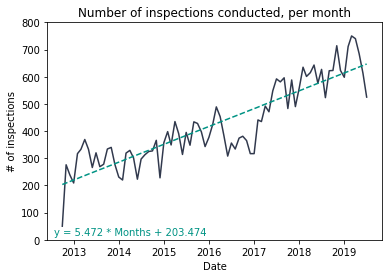

In [ ]:
data = insp.groupby(pd.Grouper(freq="M", key='INSPECTDATE')).size()
plt.plot(data, color='#31394d')
plt.ylim((0,800))
plt.title("Number of inspections conducted, per month")
plt.ylabel("# of inspections")
plt.xlabel("Date")

# calc the trendline
z = numpy.polyfit(list(range(len(data))), data.values, 1)
p = numpy.poly1d(z)
plt.plot(data.index, p(list(range(len(data)))), color='#009384', linestyle='--')
# the line equation:
plt.figtext(x=.14, y=.14, s="y = %.3f * Months + %.3f"%(z[0],z[1]), color='#009384')

plt.show()

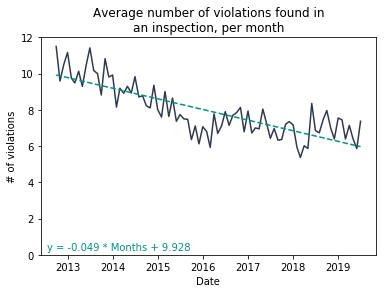

In [ ]:
data = viol.groupby([pd.Grouper(freq="M", key='INSPECTDATE'), viol['PERMITID']]).size().rename("VIOLCOUNT").groupby(level=0).mean()
plt.plot(data, color='#31394d')
plt.ylim((0,12))
plt.title("Average number of violations found in\nan inspection, per month")
plt.ylabel("# of violations")
plt.xlabel("Date")

# calc the trendline
z = numpy.polyfit(list(range(len(data))), data.values, 1)
p = numpy.poly1d(z)
plt.plot(data.index, p(list(range(len(data)))), color='#009384', linestyle='--')
# the line equation:
plt.figtext(x=.14, y=.14, s="y = %.3f * Months + %.3f"%(z[0],z[1]), color='#009384')

plt.show()

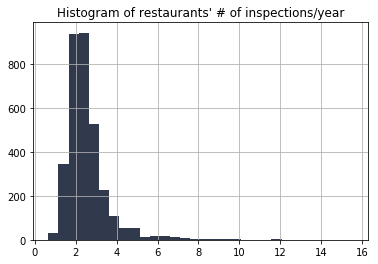

In [ ]:
insp.groupby('HSISID').size().div(insp.groupby('HSISID')['INSPECTDATE'].apply(lambda s:(s.max()-s.min()).days/365
                                                                             if len(s)>1 else None)).dropna().hist(bins=30, color='#31394d')
plt.title("Histogram of restaurants' # of inspections/year")
plt.show()

## Modeling
Build a model that can be used *(prior to an inspection being performed)* to predict the likelihood of an inspection resulting in a score that is "less than 93".

**Approach:**

We will first engineer a set of features from what we know about each restaurant. This set will be split into a train and test set using a 70/30 split. Using appropriate models and grid search to select optimum parameters, we'll identify the best model using cross validation within the training set, and then the model that performs best on the reserved testing set will be selected for production.

**Feature engineering:**

Features will include:
* the number of days the restaurant has been open (`TIMEOPEN`, integer)
* the number of days since the restaurant was last inspected (`TIMESINCE`, integer)
* the number of other restaurants (unique HSISIDs) with the same name (`CHAINCOUNT`, integer)
* the number of inspections for the restaurant (`INSPCOUNT`, integer)
* whether the restaurant has ever needed a re-inspection (`WASREINSP`, binary)
* the average number of violations per inspection for that restaurant (`AVGVIOL`, float)

Just for fun and in case of some seasonality to inspections, we'll throw in cyclical features for month:
* `SINMONTH` (float)
* `COSMONTH` (float)

Including preexisting features:
* `FACILITYTYPE` (categorical and will be converted to dummy variables)
* `CITY` (categorical and will be converted to dummy variables)
* `POSTALCODE` (integer, due to the fact that zipcodes that are close in number tend to be geographically similar as well)
* `AREACODE` (categorical, will be extracted from the existing `PHONE NUMBER` field

Wrapping in a few details on the restaurant's most recent inspection, prior to that in question:
* the type of the restaurant's most recent inspection (`TYPE_previous`, categorical to dummy)
* the inspector who completed the most recent inspection (`INSPECTOR_previous`, categorical to dummy)
* the previous inspection score (`SCORE_previous`, float)

Lastly, we will parse the text in the restaurant's `NAME`, in hopes of extracting some insight into the cuisine type or food style (ie. `buffet` might indicate a higher chance of failing inspection). I've arbitrarily decided to choose the top 40 words from restaurant `NAME`, using most frequent words.

In [ ]:
features = insp[['HSISID', 'INSPECTDATE', 'SCORE', 'INSPECTOR', 'TYPE']].join(
    rest.set_index('HSISID')[['NAME', 'CITY', 'RESTAURANTOPENDATE', 'FACILITYTYPE', 'PHONENUMBER']], on='HSISID', how='left')

# calculate number of unique HSISID's with the same name (# of chain locations, maybe)
features = features.join((features.groupby('NAME')['HSISID'].nunique()).rename('CHAINCOUNT'), on='NAME')

# calculate number of inspections
features = features.join(insp.groupby('HSISID').size().rename("INSPCOUNT").reindex(features['HSISID'].unique(), fill_value=0), on='HSISID')

# whether the restaurant ever needed a re-inspection
features['WASREINSP'] = features['HSISID'].isin(insp.loc[insp['TYPE']=='Re-Inspection', 'HSISID'].unique()).astype(int)

# average number of violations per inspection
features = features.join(insp.groupby(['HSISID', 'INSPECTDATE']).size().reindex(features[['HSISID', 'INSPECTDATE']], fill_value=0).mean(level=0).rename("AVGVIOL"),
                        on='HSISID')

# self-merge to get information about previous inspection
features = features.groupby('HSISID')[['SCORE', 'INSPECTOR', 'TYPE', 'INSPECTDATE']].apply(lambda group:
             pd.concat([group.add_suffix('_previous'),
                        group.shift(-1).add_suffix('_current')],
                       axis=1, sort=True)).drop(['INSPECTOR_current', 'TYPE_current'], axis=1).\
rename(columns={'INSPECTDATE_current':'INSPECTDATE'}).\
merge(features, on=['HSISID', 'INSPECTDATE'], how='right').drop_duplicates()


# time features
features['TIMEOPEN'] = (features['INSPECTDATE'] - features['RESTAURANTOPENDATE']).dt.days
features.loc[features['INSPECTDATE_previous'].isnull(), 'INSPECTDATE_previous'] = features['RESTAURANTOPENDATE']
features['TIMESINCE'] = (features['INSPECTDATE'] - features['INSPECTDATE_previous']).dt.days
from numpy import sin, cos
from math import pi
features['SINMONTH'] = features['INSPECTDATE'].dt.month.apply(lambda x:sin(2*pi*x/12))
features['COSMONTH'] = features['INSPECTDATE'].dt.month.apply(lambda x:cos(2*pi*x/12))

# derive area code feature as dummy columns
features = pd.concat([features, 
                      pd.get_dummies(features['PHONENUMBER'].str[1:4])],
                     axis=1)

# drop extra columns
features = features.drop(['INSPECTOR', 'TYPE', 'RESTAURANTOPENDATE', 'INSPECTDATE_previous', 'SCORE_current', 'PHONENUMBER'], 
                         axis=1).set_index(['HSISID', 'INSPECTDATE'])

# save memory
#del insp, rest, viol

features.head(2)

SCORE_previous INSPECTOR_previous TYPE_previous  \
HSISID     INSPECTDATE                                                    
4092010018 2013-06-25             97.0        James Smith    Inspection   
           2014-04-17             94.5        James Smith    Inspection   

                        SCORE        NAME     CITY FACILITYTYPE  CHAINCOUNT  \
HSISID     INSPECTDATE                                                        
4092010018 2013-06-25    94.5  angus barn  raleigh   Restaurant           1   
           2014-04-17    97.5  angus barn  raleigh   Restaurant           1   

                        INSPCOUNT  WASREINSP ...   904  908  910  918  919  \
HSISID     INSPECTDATE                       ...                             
4092010018 2013-06-25          11          0 ...     0    0    0    0    1   
           2014-04-17          11          0 ...     0    0    0    0    1   

                        941  954  978  984  989  
HSISID     INSPECTDATE                           
4092010018 2013-06-25     0    0    0    0    0  
           2014-04-17     0    0    0    0    0  

[2 rows x 55 columns]

In [ ]:
# inpute some variables that have missing values
features.loc[features['SCORE_previous'].isnull(), 'SCORE_previous'] = features['SCORE_previous'].mean() # fill with mean
features.loc[features['INSPECTOR_previous'].isnull(), 'INSPECTOR_previous'] = 'none' # simply add a new category
features.loc[features['TYPE_previous'].isnull(), 'TYPE_previous'] = 'none' # simply add a new category

features['NAME'].fillna('', inplace=True)
features['CHAINCOUNT'].fillna(1, inplace=True)

C:\Users\MPAIGE\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2819: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [ ]:
# column size explodes from here as we add columns for words in the restaurant name
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', binary=True, max_features=40)

features = pd.concat([pd.get_dummies(features.drop('NAME', axis=1), drop_first=True), 
           pd.DataFrame(vectorizer.fit_transform(features['NAME']).todense().astype(int),
             columns=vectorizer.vocabulary_, index=features.index)],
          axis=1)
features.head(2)

SCORE_previous  SCORE  CHAINCOUNT  INSPCOUNT  \
HSISID     INSPECTDATE                                                 
4092010018 2013-06-25             97.0   94.5           1         11   
           2014-04-17             94.5   97.5           1         11   

                        WASREINSP  AVGVIOL  TIMEOPEN  TIMESINCE      SINMONTH  \
HSISID     INSPECTDATE                                                          
4092010018 2013-06-25           0      1.0      8089        211  1.224647e-16   
           2014-04-17           0      1.0      8385        296  8.660254e-01   

                        COSMONTH     ...      express  cary  creek  lowes  \
HSISID     INSPECTDATE               ...                                    
4092010018 2013-06-25       -1.0     ...            0     0      0      0   
           2014-04-17       -0.5     ...            0     0      0      0   

                        lion  produce  meat  middle  wcid  elementary  
HSISID     INSPECTDATE                                                 
4092010018 2013-06-25      0        0     0       0     0           0  
           2014-04-17      0        0     0       0     0           0  

[2 rows x 162 columns]

**Modeling:**

We'll split the dataset with known scores into a training and a testing set, using the training set to determine the best model parameters and then the reserved testing set to choose the best between different model types.

The dataset is imbalanced (more inspections passed than failed by a large margin), so need to use models robust to class imbalance (such as tree-based models). We'll use cross validation with the following classifiers:
* decision tree
* bagging
* boosting
* random forest

After grid search cross validation, the parameter set with the lowest log loss will be chosen for each model. Then, we'll select the best model type overall (still using lowest log loss), and use this to predict on the unknown dataset.

In [ ]:
# split data with known scores into a train and test set for model building/validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features.drop('SCORE', axis=1)[features['SCORE'].notna()],
                                                    (features.loc[features['SCORE'].notna(), 'SCORE']<93).astype(int), 
                                                    test_size=.3, random_state=1)

In [ ]:
# evaluate a naive prediction - no inspections will come back with score<93
from numpy import zeros
from sklearn.metrics import log_loss
naive_score = log_loss(y_test, zeros(y_test.shape))
print("Naive log-loss:", naive_score)

# any models should perform better than this (have a smaller log-loss metric) to conclude that signal is being captured

Naive log-loss: 3.1738156545715404


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree = DecisionTreeClassifier(random_state=1)
grid = GridSearchCV(tree, param_grid={'max_depth':[3,5,7,12],
                                     'max_features':[.5,.8,1.]},
                   scoring='neg_log_loss', cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

tree = grid.best_estimator_
y_pred = tree.predict(X_test)
tree_score = log_loss(y_test, y_pred)

print("Single decision tree guessed {} inspections would fail, for log-loss of {}".format(y_pred.sum(), tree_score))
if tree_score<naive_score:
    print("This model surpassed a naive forecast w/ parameters", grid.best_params_)
export_graphviz(tree, out_file='tree.dot', feature_names=X_train.columns, impurity=False, label=None, proportion=True)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.1min finished


Single decision tree guessed 397 inspections would fail, for log-loss of 3.124290991843056
This model surpassed a naive forecast w/ parameters {'max_depth': 3, 'max_features': 1.0}


In [ ]:
from sklearn.ensemble import BaggingClassifier

bags = BaggingClassifier(random_state=1)
grid = GridSearchCV(bags, param_grid={'n_estimators':[20,150,250],
                                     'max_samples':[.5,.8]},
                   scoring='neg_log_loss', cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

bags = grid.best_estimator_
y_pred = bags.predict(X_test)
bags_score = log_loss(y_test, y_pred)

print("Bagging guessed {} inspections would fail, for log-loss of {}".format(y_pred.sum(), bags_score))
if bags_score<naive_score:
    print("This model surpassed a naive forecast w/ parameters", grid.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:  3.9min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  5.0min finished


Bagging guessed 343 inspections would fail, for log-loss of 3.0318145601589728
This model surpassed a naive forecast w/ parameters {'max_samples': 0.5, 'n_estimators': 250}


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

boost = GradientBoostingClassifier(random_state=1)
grid = GridSearchCV(bags, param_grid={'n_estimators':[200,350],
                                     'max_features':[.6,.8,1.]},
                   scoring='neg_log_loss', cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

boost = grid.best_estimator_
y_pred = boost.predict(X_test)
boost_score = log_loss(y_test, y_pred)

print("Boosting guessed {} inspections would fail, for log-loss of {}".format(y_pred.sum(), boost_score))
if boost_score<naive_score:
    print("This model surpassed a naive forecast w/ parameters", grid.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:  5.9min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  7.8min finished


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1)
grid = GridSearchCV(bags, param_grid={'n_estimators':[200,350],
                                     'max_samples':[.3,.5,.8],
                                     'max_features':[.3,.5,.8]},
                   scoring='neg_log_loss', cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

rf = grid.best_estimator_
y_pred = rf.predict(X_test)
rf_score = log_loss(y_test, y_pred)

print("Random Forest guessed {} inspections would fail, for log-loss of {}".format(y_pred.sum(), rf_score))
if rf_score<naive_score:
    print("This model surpassed a naive forecast w/ parameters", grid.best_params_)

**Conclusions:**

The best out-of-sample model using log loss will be used to predict on the unknown inspections.